In [1]:
from pgmpy.models import BayesianModel,BayesianNetwork 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score, mean_squared_error,precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, ExpectationMaximization, IVEstimator
from pgmpy.inference import VariableElimination, BeliefPropagation
import bnlearn as bn
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read Data

In [2]:
crash = pd.read_csv('data/crash_nyc_2021.csv').reset_index().iloc[:,1:]
crash = crash.loc[(crash['Duration (min)']>0)&(crash['Duration (min)']<=150)].reset_index()
crash['Duration_class'] = pd.cut(crash['Duration (min)'], [0,30,60,90,120], right=True, labels=[0,1,2,3])
crash = crash.dropna()
#target_var = 'Duration (min)'
target_var = 'Duration_class'

column_clear = ['Start Date Time','Direction','County', 'Year', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', target_var]

crash['Start Date Time'] = pd.to_datetime(crash['Start Date Time'])

data = crash[crash['Start Date Time'].dt.year.isin([2021])].iloc[:,1:]

data = data[column_clear].iloc[:,1:]

In [3]:
train, test = train_test_split(data, test_size=0.25)

In [4]:
train_target = train.pop('Duration_class')

In [5]:
Xtrain, Xval, ytrain, yval = train_test_split(train, train_target, test_size=0.1, random_state=0)
valid = pd.concat([Xval, yval], axis='columns')
dfnum = pd.concat([Xtrain, ytrain], axis='columns')
dfnum

,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
4960,3,3,6,0,0,0,1,0,1,2,1,2
5503,1,3,6,0,1,0,0,1,1,3,1,2
5156,4,3,6,1,0,0,0,0,1,2,1,2
4818,2,1,6,0,1,0,1,0,1,1,1,2
2280,4,1,6,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,4,3,6,0,1,0,2,0,0,1,0,0
1629,3,2,6,1,0,0,2,0,0,2,0,0
3206,2,0,6,0,1,0,0,1,1,1,0,1
1044,4,2,6,0,0,0,1,0,0,1,0,0


# Define Performance Metric: Accuracy Score, Precision, Recall, F1-Measurement

In [6]:
#Get accuracy for classification task
def get_acc(model, df, col):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = accuracy_score(df[col], pred)
    print('Accuracy -', acc)
    return acc

In [7]:
def get_acc_label(model, df, col, labels):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = precision_recall_fscore_support(df[col], pred, average=None, labels=labels)
    print('precision, recall, f1 -', acc)
    return acc

# Decision Tree

### Using decision tree to analyze data can be limiting because "average" values at thenodes offer only a general idea about the impact of every factor associated with each node.

In [8]:
# Fitting Classifier to the Training Set
DTmodel = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
DTmodel.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

### The nodes of traditional classification trees represent a pre-specified mean value for the categorical value thereby constructing a pre-determined path for the decision-making process. This approach clearly neglects the stochastic nature of the parent-child relationships that one would like to capture in a decision tree.

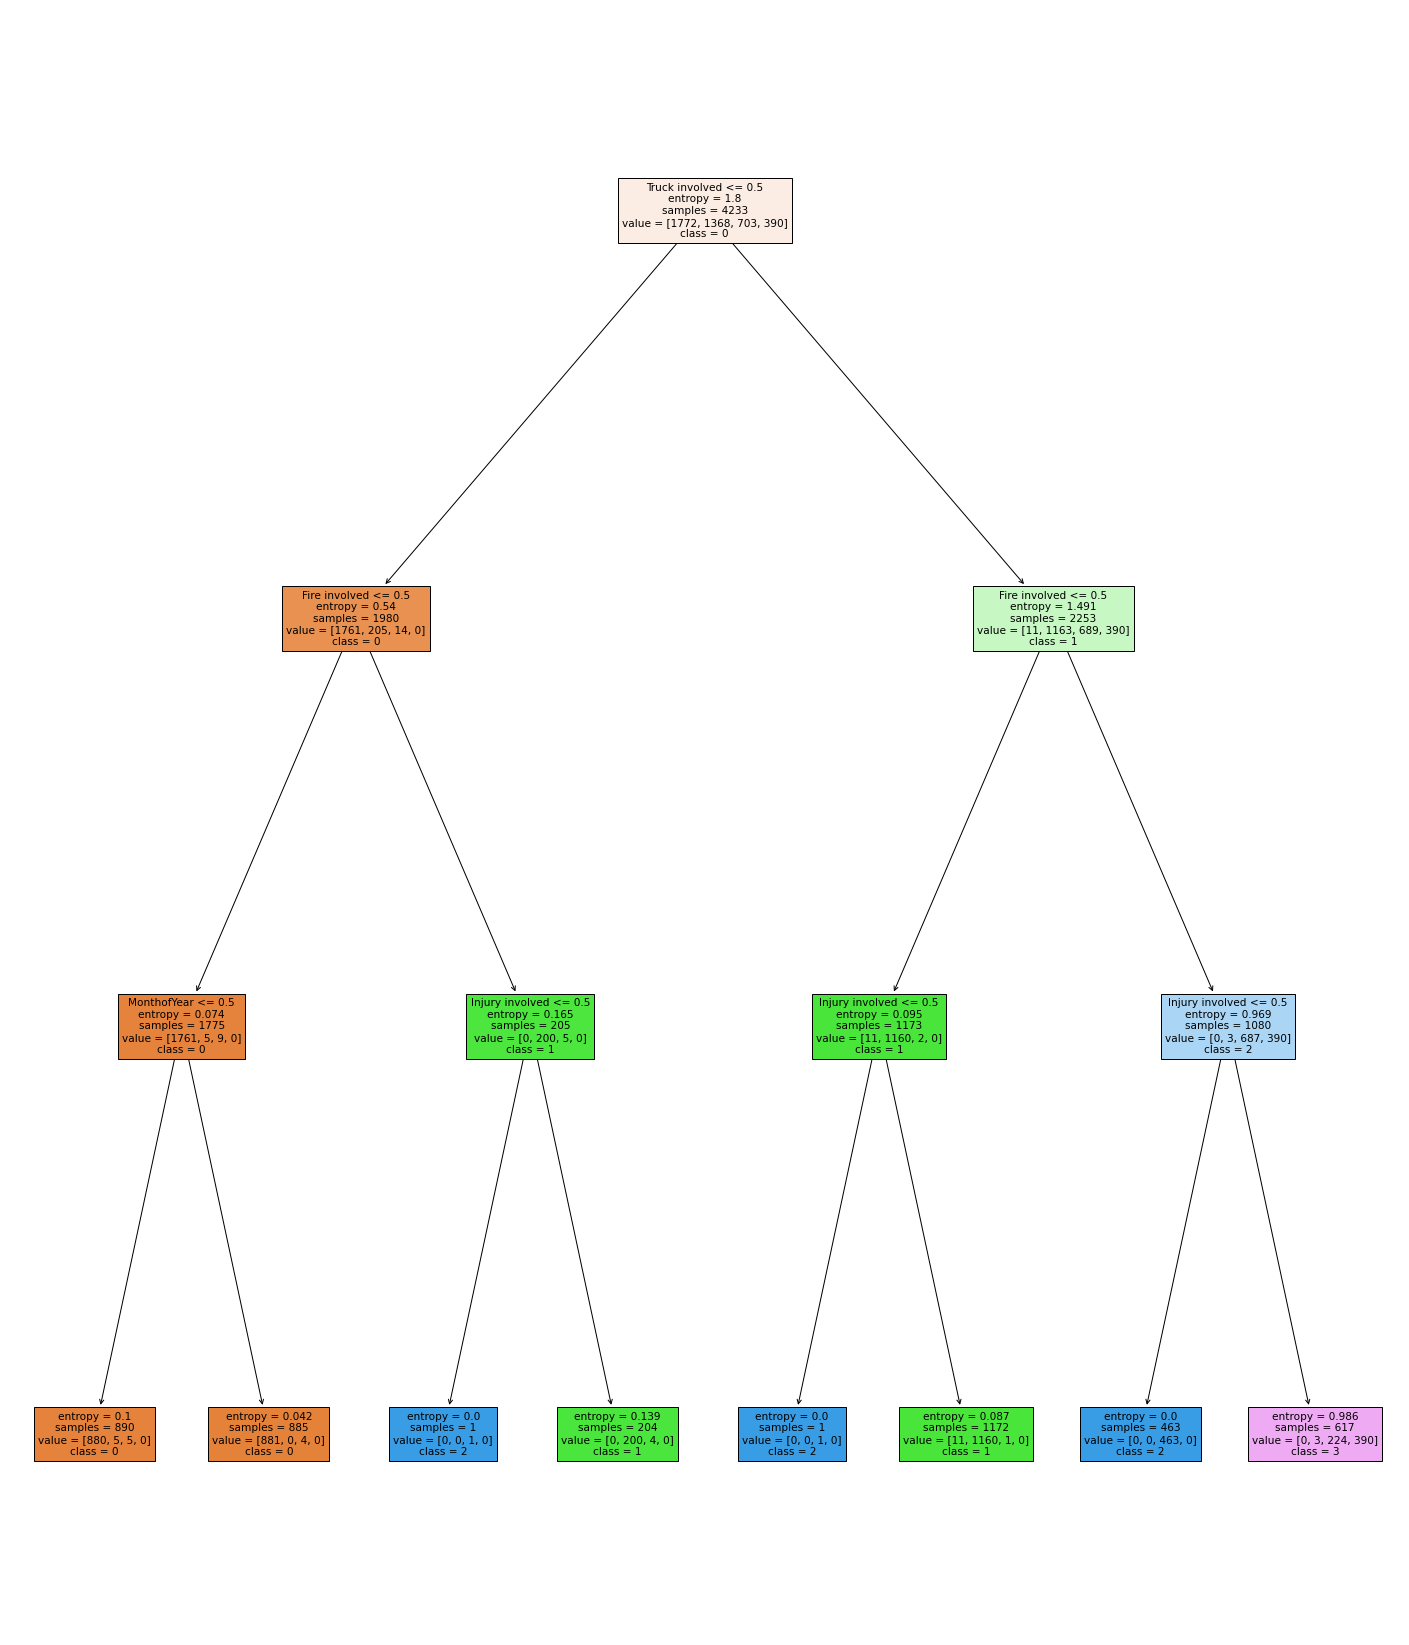

In [9]:
# Visualize the tree by graphiz
import graphviz
from sklearn import tree
feature_names = dfnum.columns[:-1]
class_names=['0','1','2','3','4']
fig = plt.figure(figsize=(25,30))
_ = tree.plot_tree(DTmodel, feature_names=feature_names, class_names=class_names, filled=True)

# Bayesian Network

# Structure Learning

In [10]:
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='cl', root_node='Duration_class', bw_list_method='nodes', verbose=3)
#DAG = bn.structure_learning.fit(data,methodtype='cl', scoretype='bdeu')
#DAG = bn.structure_learning.fit(data,methodtype='naivebayes', scoretype='bdeu', root_node='Duration_class')


[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [chow-liu]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


In [11]:
#model.edges()
DAG['model_edges']

[('Duration_class', 'Truck involved'),
 ('Duration_class', 'Injury involved'),
 ('Duration_class', 'Fire involved'),
 ('Duration_class', 'Direction'),
 ('Direction', 'County'),
 ('Direction', 'Lane Closure Type'),
 ('Lane Closure Type', 'TOD'),
 ('Lane Closure Type', 'MonthofYear'),
 ('TOD', 'PeakHour'),
 ('TOD', 'DayofWeek'),
 ('DayofWeek', 'Year')]

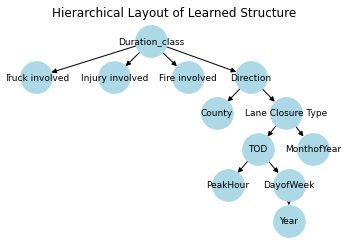

In [12]:
# Plot graph
#G = bn.plot(DAG)
# Convert Bayesian network structure to a hierarchical structure (DAG)
G = nx.DiGraph()
#G.add_edges_from(model.edges())
G.add_edges_from(DAG['model_edges'])

# Plot the hierarchical structure
plt.title('Hierarchical Layout of Learned Structure')
pos =graphviz_layout(G, prog='dot')
#fig=plt.figure(figsize=(20,10))
nx.draw(G, pos, with_labels=True, arrows=True, node_color="lightblue", node_size=1000, font_size=9)
plt.savefig('BN_structure.png')

# Parameter Learning

In [13]:
# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);
model = BayesianNetwork(ebunch=DAG['model_edges'])
bayes = BayesianEstimator(model=model, data = data)
model.fit(dfnum, estimator=BayesianEstimator, prior_type='BDeu',equivalent_sample_size=10,
          complete_samples_only=False)
model.local_independencies(bayes.variables)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Duration_class:
+-------------------+----------+
| Duration_class(0) | 0.386394 |
+-------------------+----------+
| Duration_class(1) | 0.309192 |
+-------------------+----------+
| Duration_class(2) | 0.182114 |
+-------------------+----------+
| Duration_class(3) | 0.122301 |
+-------------------+----------+
[bnlearn] >CPD of Truck involved:
+-------------------+---------------------+---------------------+--------------------+-------------------+
| Duration_class    | Duration_class(0)   | Duration_class(1)   | Duration_class(2)  | Duration_class(3) |
+-------------------+---------------------+---------------------+--------------------+-------------------+
| Truck involved(0) | 0.9327398615232443  | 0.20395550061804696 | 0.1458551941238195 | 0.1953125         |
+------------

(Direction ⟂ Fire involved, Truck involved, Injury involved | Duration_class)
(County ⟂ Fire involved, Truck involved, Duration_class, PeakHour, DayofWeek, Lane Closure Type, Injury involved, MonthofYear, Year, TOD | Direction)
(Year ⟂ Fire involved, Truck involved, Direction, Duration_class, PeakHour, County, Lane Closure Type, Injury involved, MonthofYear, TOD | DayofWeek)
(TOD ⟂ Fire involved, Truck involved, Injury involved, Direction, Duration_class, MonthofYear, County | Lane Closure Type)
(PeakHour ⟂ Fire involved, Truck involved, Direction, Duration_class, DayofWeek, County, Lane Closure Type, Injury involved, MonthofYear, Year | TOD)
(DayofWeek ⟂ Fire involved, Truck involved, Direction, Duration_class, PeakHour, County, Lane Closure Type, Injury involved, MonthofYear | TOD)
(MonthofYear ⟂ Fire involved, Truck involved, Direction, Duration_class, PeakHour, County, Injury involved, DayofWeek, Year, TOD | Lane Closure Type)
(Injury involved ⟂ Fire involved, Truck involved, Direc

# Validation

In [14]:
acc1 = get_acc(model, valid, 'Duration_class')

  0%|          | 0/370 [00:00<?, ?it/s]

     Duration_class
0                 0
1                 2
2                 0
3                 0
4                 3
..              ...
466               0
467               2
468               1
469               0
470               1

[471 rows x 1 columns]
Accuracy - 0.9341825902335457


In [15]:
acc2 = get_acc_label(model, valid, 'Duration_class', [0,1,2,3])

  0%|          | 0/370 [00:00<?, ?it/s]

     Duration_class
0                 0
1                 2
2                 0
3                 0
4                 3
..              ...
466               0
467               2
468               1
469               0
470               1

[471 rows x 1 columns]
precision, recall, f1 - (array([0.99579832, 0.936     , 1.        , 0.66666667]), array([0.96734694, 1.        , 0.64615385, 1.        ]), array([0.98136646, 0.96694215, 0.78504673, 0.8       ]), array([245, 117,  65,  44], dtype=int64))


# Inference: Dealing with Missing Information

### BN predicts the TID based on probabilistic inference, which is capable of dealing with missing information. The following two scenarios show the prediction of TID with some missing variables.

## Scenario#1: Predicting TID with missing Fire Truck Involvement information

In [186]:
#Inference with complete information
inference = VariableElimination(model)
# evidence = valid.iloc[0,:-1]
# result=inference.query(variables=['Duration_class'], evidence=evidence)
# print(result)

In [187]:
#Inference with missing Fire Truck Involvement information
evidence = {'Direction':4, 
            'County': 3, 
            'Year': 6, 
            'TOD': 0, 
            'PeakHour': 1, 
            'DayofWeek': 0, 
            'MonthofYear': 1,
           'Injury involved': 1,
           'Truck involved': 1,
           'Lane Closure Type': 1}
           #'Fire involved': 0}
result=inference.query(variables=['Duration_class'], evidence=evidence)
print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0003 |
+-------------------+-----------------------+
| Duration_class(1) |                0.6560 |
+-------------------+-----------------------+
| Duration_class(2) |                0.1455 |
+-------------------+-----------------------+
| Duration_class(3) |                0.1982 |
+-------------------+-----------------------+


## Scenario#2: Predicting TID with missing Fire Truck and Injury information

In [188]:
#Inference with missing Fire Truck Involvement and Injury information
evidence = {'Direction':4, 
            'County': 3, 
            'Year': 6, 
            'TOD': 0, 
            'PeakHour': 1, 
            'DayofWeek': 0, 
            'MonthofYear': 1,
           'Truck involved': 1,
           'Lane Closure Type': 1}
result=inference.query(variables=['Duration_class'], evidence=evidence)
print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0049 |
+-------------------+-----------------------+
| Duration_class(1) |                0.5135 |
+-------------------+-----------------------+
| Duration_class(2) |                0.3264 |
+-------------------+-----------------------+
| Duration_class(3) |                0.1552 |
+-------------------+-----------------------+


# Decision-making using probabilistic inference

### The probabilistic inference in BN also enables to manipulate the certainty in the selected variables, thereby ensuring the creation of scenario-based network structure

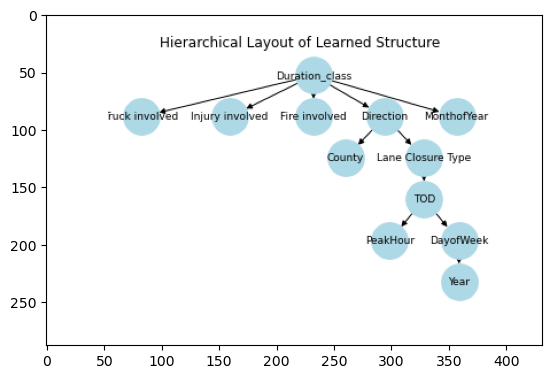

In [189]:
img=mpimg.imread('BN_structure.png')
plt.imshow(img)

In [191]:
evidence = {'Injury involved': 1,
           'Truck involved': 1,
           'Lane Closure Type': 1,
           'Fire involved': 1}
model.nodes()
for node in model.nodes():
    if node not in evidence:
        result=inference.query(variables=[node], evidence=evidence)
        print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0000 |
+-------------------+-----------------------+
| Duration_class(1) |                0.2371 |
+-------------------+-----------------------+
| Duration_class(2) |                0.2889 |
+-------------------+-----------------------+
| Duration_class(3) |                0.4741 |
+-------------------+-----------------------+
+--------------+------------------+
| Direction    |   phi(Direction) |
+==============+==================+
| Direction(1) |           0.2585 |
+--------------+------------------+
| Direction(2) |           0.2547 |
+--------------+------------------+
| Direction(3) |           0.2685 |
+--------------+------------------+
| Direction(4) |           0.2126 |
+--------------+------------------+
| Direction(5) |           0.0057 |
+--------------+------------------+
+-----------+-------------

# Prediction

In [192]:
result_pred = model.predict(test.iloc[:,:-1])

  0%|          | 0/907 [00:00<?, ?it/s]

In [193]:
acc_test=accuracy_score(test['Duration_class'], result_pred)
acc_label_test=precision_recall_fscore_support(test['Duration_class'], result_pred, labels=[0,1,2,3])
print("Test accuracy score -", acc_test)
print("Test precision, recall, F1-score and Sample Size -", acc_label_test)

Test accuracy score - 0.9343530911408541
Test precision, recall, F1-score and Sample Size - (array([0.99544073, 0.95857988, 1.        , 0.66806723]), array([0.96893491, 0.99794661, 0.67206478, 1.        ]), array([0.982009  , 0.9778672 , 0.80387409, 0.80100756]), array([676, 487, 247, 159]))


In [194]:
test['Duration_class']
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3])
ypred = label_binarize(result_pred, classes=[0,1,2,3])

# AUC-ROC Curve

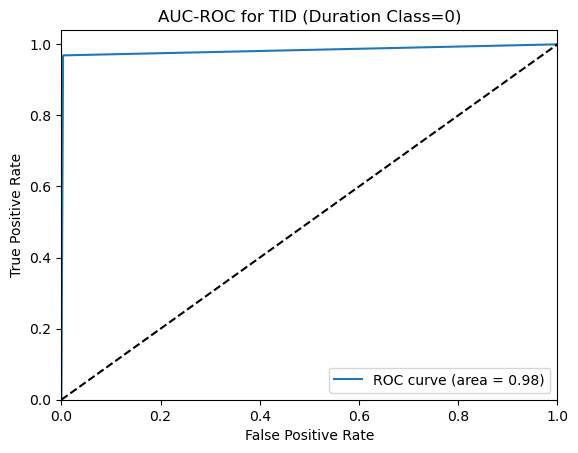

<Figure size 640x480 with 0 Axes>

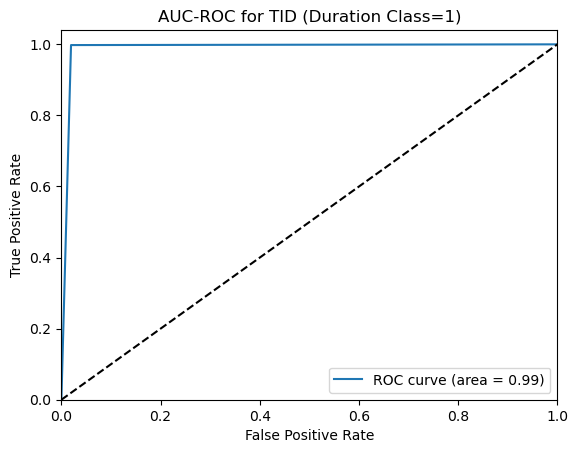

<Figure size 640x480 with 0 Axes>

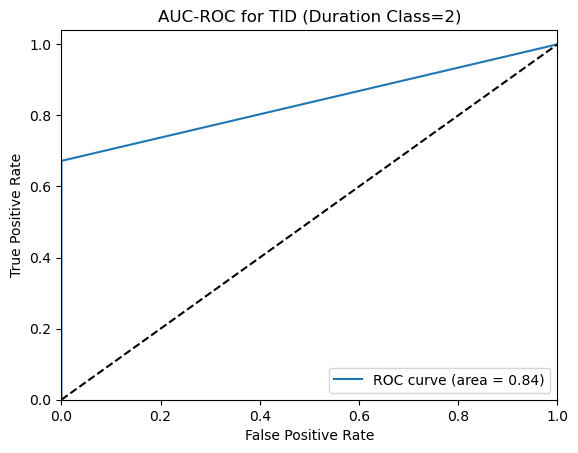

<Figure size 640x480 with 0 Axes>

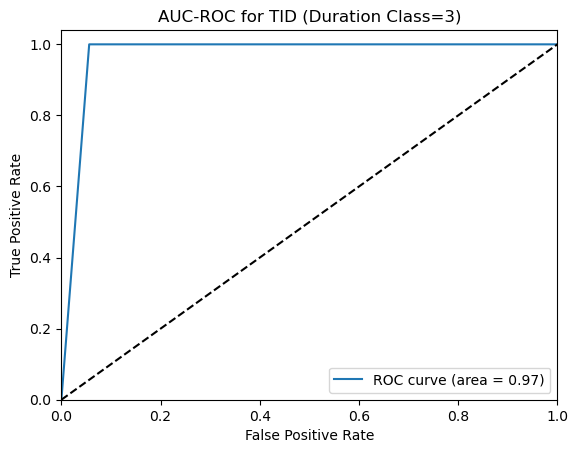

<Figure size 640x480 with 0 Axes>

In [200]:
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3])
fpr, tpr = dict(), dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest[:,i], ypred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.04])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC for TID (Duration Class=%0.0f)' % i)
    plt.legend(loc='lower right')
    plt.show()
    plt.savefig('AUC_ROC for TID (Duration Class=%0.0f).png' %i)